In [105]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import QUANTAXIS as QA
import pandas as pd
import numpy as np
import pyecharts
import talib

#设定绘图的默认大小
import matplotlib
matplotlib.rcParams["figure.figsize"]=[16,5]

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = ['Noto Sans CJK SC','SimHei']
matplotlib.rcParams['axes.unicode_minus']=False #用来正常显示负号

import matplotlib.pyplot as plt

#加载 seaborn，并且设置默认使用 seaborn
import seaborn as sns
sns.set(font=['Noto Sans CJK SC','SimHei'])

# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all" 

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [106]:
stock_code='601398'
benchmark_code='399300'
start_time='2005-01-01'
end_time='2018-12-31'

data_raw=QA.QA_fetch_stock_day_adv(stock_code, start_time, end_time).to_qfq().data.reset_index().set_index('date')
data_raw.head(1)

,code,open,high,low,close,volume,amount,preclose,adj
date,,,,,,,,,
2006-10-27,601398,1.992133,2.01557,1.910104,1.921823,4.407654e+07,8.725310e+09,NaN,0.585922


In [3]:
data=data_raw.drop(columns=['code','amount','preclose','adj'])
data.head(1)

,open,high,low,close,volume
date,,,,,
2006-10-27,1.992133,2.01557,1.910104,1.921823,4.407654e+07


## 对数据进行包装

### 增加特性数据

In [4]:
def augFeatures(train):
    df=train.copy()
    df["year"] = df.index.year
    df["month"] = df.index.month
    df["date"] = df.index.day
    df["day"] = df.index.dayofweek
    return df

### 正则化

In [5]:
def normalize(train):
    return train.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

### 其他方法

In [81]:
def buildData(df,pastDays=30,futureDays=5):
    """取 `pastDays` 的数据作为计算数据，取 `futureDays` 的 `close` %save据作为测算数据。
    返回的X集合中包含类型为 `DataFrame` ，Y集合中包含为 `Series`。"""
    X,Y=[],[]
    for i in range(df.shape[0]-pastDays-futureDays):
        X.append(df.iloc[i:i+pastDays])
        Y.append(df.iloc[i+pastDays:i+pastDays+futureDays]['close'])
    return X,Y

# def splitBuildData(X,Y,test_size=0.2,random_state=10,shuffle=True):
#     """调用 `sklearn.model_selection.train_test_split` callable分训练集和测试集。
#     Args:
#         shuffle: 是否打乱数据。默认为 `True`。
        
#     Returns:
#         返回内容为：X_train, X_test, y_train, y_test。
#         其中 X_train和y_train配对，X_test和y_test配对。"""
#     return train_test_split(X,Y,test_size=test_size,random_state=random_state,shuffle=shuffle)

def toNpArray(d):
    return np.array([np.array(x.values) for x in d])

## 数据演示

In [77]:
data = data_raw.drop(columns=['code','amount','preclose','adj'])
# 包装数据
data_Aug = augFeatures(data)
# 归一化数据
data_norm = normalize(data_Aug)
# 构建结果集
X,Y=buildData(data_norm)
# 按顺序拆分数据和结果
X_train, X_test, y_train, y_test = splitBuildData(X, Y,shuffle=False)

In [79]:
#X_train集合中每一个元素（30天的数据）与X集合中每一个元素的对应关系（因为是按照顺序拆分的）
X_train[0]
np.array([np.array(x.values) for x in X])[0]

,open,high,low,close,volume,year,month,date,day
date,,,,,,,,,
2006-10-27,-0.290901,-0.286750,-0.305056,-0.297344,0.947017,-0.535039,0.303473,0.362010,0.497366
2006-10-30,-0.305110,-0.299520,-0.306172,-0.296279,0.080294,-0.535039,0.303473,0.462010,-0.502634
2006-10-31,-0.304017,-0.298456,-0.302826,-0.295213,0.032970,-0.535039,0.303473,0.495343,-0.252634
2006-11-01,-0.301831,-0.300584,-0.302826,-0.295213,-0.004811,-0.535039,0.394382,-0.504657,-0.002634
2006-11-02,-0.301831,-0.301648,-0.306172,-0.297344,0.011611,-0.535039,0.394382,-0.471323,0.247366
2006-11-03,-0.305110,-0.294199,-0.303941,-0.288819,0.098982,-0.535039,0.394382,-0.437990,0.497366
2006-11-06,-0.298552,-0.293135,-0.298366,-0.286688,0.025147,-0.535039,0.394382,-0.337990,-0.502634
2006-11-07,-0.293087,-0.287814,-0.292790,-0.284557,0.058874,-0.535039,0.394382,-0.304657,-0.252634
2006-11-08,-0.290901,-0.291007,-0.295020,-0.288819,0.002545,-0.535039,0.394382,-0.271323,-0.002634


array([[-0.290901  , -0.28674996, -0.30505644, -0.2973442 ,  0.94701728,
        -0.53503852,  0.30347321,  0.36200997,  0.49736574],
       [-0.30510993, -0.29952003, -0.30617156, -0.29627859,  0.08029418,
        -0.53503852,  0.30347321,  0.46200997, -0.50263426],
       [-0.30401693, -0.29845586, -0.30282621, -0.29521298,  0.03296992,
        -0.53503852,  0.30347321,  0.4953433 , -0.25263426],
       [-0.30183094, -0.3005842 , -0.30282621, -0.29521298, -0.00481098,
        -0.53503852,  0.3943823 , -0.5046567 , -0.00263426],
       [-0.30183094, -0.30164837, -0.30617156, -0.2973442 ,  0.01161062,
        -0.53503852,  0.3943823 , -0.47132336,  0.24736574],
       [-0.30510993, -0.29419917, -0.30394132, -0.28881931,  0.09898188,
        -0.53503852,  0.3943823 , -0.43799003,  0.49736574],
       [-0.29855196, -0.293135  , -0.29836574, -0.28668809,  0.02514733,
        -0.53503852,  0.3943823 , -0.33799003, -0.50263426],
       [-0.29308699, -0.28781414, -0.29279015, -0.28455687,  0

In [82]:
#将原本的集合中包含DataFrame的X，或者集合中包含Series的Y，转换成np.array类型
X_train=toNpArray(X_train)
X_test=toNpArray(X_test)
y_train=toNpArray(y_train)
y_test=toNpArray(y_test)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2325, 30, 9), (582, 30, 9), (2325, 5), (582, 5))

https://keras.io/zh/layers/recurrent/#lstm
    
[Sequential 顺序模型指引](https://keras.io/zh/getting-started/sequential-model-guide/)

In [111]:
def buildManyToManyModel(shape):
    model = Sequential()
    #input_dim: 输入的维度（整数）。 将此层用作模型中的第一层时，此参数（或者，关键字参数 input_shape）是必需的。
    #input_length: 输入序列的长度，在恒定时指定。 
    #如果你要在上游连接 Flatten 和 Dense 层， 则需要此参数（如果没有它，无法计算全连接输出的尺寸）。 
    #请注意，如果循环神经网络层不是模型中的第一层， 则需要在第一层的层级指定输入长度（例如，通过 input_shape 参数）。
    model.add(LSTM(10, input_length=shape[1], input_dim=shape[2]))
    # 
    model.add(Dense(5))
    # 模型编译
    # 在训练模型之前，您需要配置学习过程，这是通过 compile 方法完成的。它接收三个参数：

    # 优化器 optimizer。它可以是现有优化器的字符串标识符，如 rmsprop 或 adagrad，也可以是 Optimizer 类的实例。
    # 详见：optimizers。
    # 损失函数 loss，模型试图最小化的目标函数。它可以是现有损失函数的字符串标识符，
    # 如 categorical_crossentropy 或 mse，也可以是一个目标函数。详见：losses。
    # 评估标准 metrics。对于任何分类问题，你都希望将其设置为 metrics = ['accuracy']。
    # 评估标准可以是现有的标准的字符串标识符，也可以是自定义的评估标准函数。
#     metrics: 在训练和测试期间的模型评估标准。通常你会使用 metrics = ['accuracy']。 
#         要为多输出模型的不同输出指定不同的评估标准，还可以传递一个字典，如 metrics = {'output_a'：'accuracy'}。
    model.compile(loss="mse", optimizer="adam",metrics=['mae', 'acc'])
    model.summary()
    return model

In [112]:
data = data_raw.drop(columns=['code','amount','preclose','adj'])
data_Aug = augFeatures(data)
data_norm = normalize(data_Aug)
X,Y=buildData(data_norm[:-200])
# X_train, X_test, y_train, y_test = splitBuildData(X, Y)

# X_train=toNpArray(X_train)
# X_test=toNpArray(X_test)
# y_train=toNpArray(y_train)
# y_test=toNpArray(y_test)

X_np=toNpArray(X)
Y_np=toNpArray(Y)

model = buildManyToManyModel(X_train.shape)
cb_loss = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
# epochs: 整数。训练模型迭代轮次。一个轮次是在整个 x 或 y 上的一轮迭代。
#     请注意，与 initial_epoch 一起，epochs 被理解为 「最终轮次」。
#     模型并不是训练了 epochs 轮，而是到第 epochs 轮停止训练。
# batch_size: 整数或 None。每次提度更新的样本数。如果未指定，默认为 32.
# validation_split: 在 0 和 1 之间浮动。用作验证集的训练数据的比例。
#     模型将分出一部分不会被训练的验证数据，并将在每一轮结束时评估这些验证数据的误差和任何其他模型指标。
#     验证数据是混洗之前 x 和y 数据的最后一部分样本中。
# shuffle: 布尔值（是否在每轮迭代之前混洗数据）或者 字符串 (batch)。
#     batch 是处理 HDF5 数据限制的特殊选项，它对一个 batch 内部的数据进行混洗。
#     当 steps_per_epoch 非 None 时，这个参数无效。
# validation_data: 元组 (x_val，y_val) 或元组 (x_val，y_val，val_sample_weights)，用来评估损失，
#     以及在每轮结束时的任何模型度量指标。模型将不会在这个数据上进行训练。
#     这个参数会覆盖 validation_split。
history=model.fit(X_np, Y_np, epochs=1000, batch_size=128, validation_split=0.15, callbacks=[cb_loss])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_10 (LSTM)               (None, 10)                800       
_________________________________________________________________
dense_10 (Dense)             (None, 5)                 55        
Total params: 855
Trainable params: 855
Non-trainable params: 0
_________________________________________________________________
Train on 2300 samples, validate on 407 samples
Epoch 1/1000
2300/2300 [==============================] - 2s 1ms/step - loss: 0.0177 - mean_absolute_error: 0.1115 - acc: 0.1852 - val_loss: 0.0942 - val_mean_absolute_error: 0.2541 - val_acc: 0.2678
Epoch 2/1000
2300/2300 [==============================] - 1s 306us/step - loss: 0.0101 - mean_absolute_error: 0.0804 - acc: 0.1652 - val_loss: 0.0766 - val_mean_absolute_error: 0.2252 - val_acc: 0.2211
Epoch 3/1000
2300/2300 [==============================] - 1s 332us/step - loss: 0.0060 - me

Epoch 38/1000
2300/2300 [==============================] - 1s 312us/step - loss: 5.3024e-04 - mean_absolute_error: 0.0155 - acc: 0.2039 - val_loss: 0.0140 - val_mean_absolute_error: 0.0776 - val_acc: 0.3022
Epoch 39/1000
2300/2300 [==============================] - 1s 306us/step - loss: 5.2722e-04 - mean_absolute_error: 0.0155 - acc: 0.2026 - val_loss: 0.0143 - val_mean_absolute_error: 0.0791 - val_acc: 0.2948
Epoch 40/1000
2300/2300 [==============================] - 1s 312us/step - loss: 5.2317e-04 - mean_absolute_error: 0.0154 - acc: 0.1991 - val_loss: 0.0138 - val_mean_absolute_error: 0.0769 - val_acc: 0.3071
Epoch 41/1000
2300/2300 [==============================] - 1s 309us/step - loss: 5.2000e-04 - mean_absolute_error: 0.0153 - acc: 0.2039 - val_loss: 0.0138 - val_mean_absolute_error: 0.0773 - val_acc: 0.2973
Epoch 42/1000
2300/2300 [==============================] - 1s 306us/step - loss: 5.1654e-04 - mean_absolute_error: 0.0153 - acc: 0.1974 - val_loss: 0.0136 - val_mean_absolu

2300/2300 [==============================] - 1s 319us/step - loss: 4.5308e-04 - mean_absolute_error: 0.0141 - acc: 0.1922 - val_loss: 0.0096 - val_mean_absolute_error: 0.0622 - val_acc: 0.2310
Epoch 78/1000
2300/2300 [==============================] - 1s 314us/step - loss: 4.5054e-04 - mean_absolute_error: 0.0140 - acc: 0.2017 - val_loss: 0.0090 - val_mean_absolute_error: 0.0590 - val_acc: 0.2408
Epoch 79/1000
2300/2300 [==============================] - 1s 313us/step - loss: 4.4947e-04 - mean_absolute_error: 0.0140 - acc: 0.2065 - val_loss: 0.0094 - val_mean_absolute_error: 0.0613 - val_acc: 0.2408
Epoch 80/1000
2300/2300 [==============================] - 1s 316us/step - loss: 4.4891e-04 - mean_absolute_error: 0.0140 - acc: 0.1965 - val_loss: 0.0092 - val_mean_absolute_error: 0.0600 - val_acc: 0.2408
Epoch 81/1000
2300/2300 [==============================] - 1s 319us/step - loss: 4.4623e-04 - mean_absolute_error: 0.0139 - acc: 0.2043 - val_loss: 0.0094 - val_mean_absolute_error: 0.06

2300/2300 [==============================] - 1s 314us/step - loss: 4.1706e-04 - mean_absolute_error: 0.0134 - acc: 0.2035 - val_loss: 0.0091 - val_mean_absolute_error: 0.0602 - val_acc: 0.2334
Epoch 117/1000
2300/2300 [==============================] - 1s 308us/step - loss: 4.1470e-04 - mean_absolute_error: 0.0133 - acc: 0.2004 - val_loss: 0.0092 - val_mean_absolute_error: 0.0605 - val_acc: 0.2383
Epoch 118/1000
2300/2300 [==============================] - 1s 294us/step - loss: 4.1391e-04 - mean_absolute_error: 0.0133 - acc: 0.2109 - val_loss: 0.0091 - val_mean_absolute_error: 0.0600 - val_acc: 0.2383
Epoch 119/1000
2300/2300 [==============================] - 1s 316us/step - loss: 4.1468e-04 - mean_absolute_error: 0.0134 - acc: 0.2139 - val_loss: 0.0095 - val_mean_absolute_error: 0.0620 - val_acc: 0.2334
Epoch 120/1000
2300/2300 [==============================] - 1s 312us/step - loss: 4.1570e-04 - mean_absolute_error: 0.0134 - acc: 0.2113 - val_loss: 0.0098 - val_mean_absolute_error: 

2300/2300 [==============================] - 1s 309us/step - loss: 3.9038e-04 - mean_absolute_error: 0.0130 - acc: 0.2304 - val_loss: 0.0121 - val_mean_absolute_error: 0.0714 - val_acc: 0.2408
Epoch 156/1000
2300/2300 [==============================] - 1s 315us/step - loss: 3.9159e-04 - mean_absolute_error: 0.0130 - acc: 0.2239 - val_loss: 0.0122 - val_mean_absolute_error: 0.0718 - val_acc: 0.2457
Epoch 157/1000
2300/2300 [==============================] - 1s 306us/step - loss: 3.9424e-04 - mean_absolute_error: 0.0131 - acc: 0.2396 - val_loss: 0.0123 - val_mean_absolute_error: 0.0728 - val_acc: 0.2432
Epoch 158/1000
2300/2300 [==============================] - 1s 309us/step - loss: 3.9400e-04 - mean_absolute_error: 0.0131 - acc: 0.2217 - val_loss: 0.0125 - val_mean_absolute_error: 0.0727 - val_acc: 0.2457
Epoch 159/1000
2300/2300 [==============================] - 1s 312us/step - loss: 3.8885e-04 - mean_absolute_error: 0.0129 - acc: 0.2365 - val_loss: 0.0117 - val_mean_absolute_error: 

2300/2300 [==============================] - 1s 318us/step - loss: 3.7414e-04 - mean_absolute_error: 0.0127 - acc: 0.2296 - val_loss: 0.0157 - val_mean_absolute_error: 0.0817 - val_acc: 0.2457
Epoch 195/1000
2300/2300 [==============================] - 1s 320us/step - loss: 3.7211e-04 - mean_absolute_error: 0.0127 - acc: 0.2235 - val_loss: 0.0165 - val_mean_absolute_error: 0.0849 - val_acc: 0.2457
Epoch 196/1000
2300/2300 [==============================] - 1s 312us/step - loss: 3.7055e-04 - mean_absolute_error: 0.0127 - acc: 0.2357 - val_loss: 0.0167 - val_mean_absolute_error: 0.0851 - val_acc: 0.2482
Epoch 197/1000
2300/2300 [==============================] - 1s 307us/step - loss: 3.7317e-04 - mean_absolute_error: 0.0128 - acc: 0.2330 - val_loss: 0.0164 - val_mean_absolute_error: 0.0845 - val_acc: 0.2482
Epoch 198/1000
2300/2300 [==============================] - 1s 306us/step - loss: 3.7231e-04 - mean_absolute_error: 0.0127 - acc: 0.2422 - val_loss: 0.0170 - val_mean_absolute_error: 

2300/2300 [==============================] - 1s 314us/step - loss: 3.6026e-04 - mean_absolute_error: 0.0126 - acc: 0.2352 - val_loss: 0.0214 - val_mean_absolute_error: 0.0983 - val_acc: 0.2482
Epoch 234/1000
2300/2300 [==============================] - 1s 309us/step - loss: 3.5833e-04 - mean_absolute_error: 0.0125 - acc: 0.2261 - val_loss: 0.0218 - val_mean_absolute_error: 0.0992 - val_acc: 0.2482
Epoch 235/1000
2300/2300 [==============================] - 1s 310us/step - loss: 3.5925e-04 - mean_absolute_error: 0.0126 - acc: 0.2404 - val_loss: 0.0210 - val_mean_absolute_error: 0.0964 - val_acc: 0.2482
Epoch 236/1000
2300/2300 [==============================] - 1s 317us/step - loss: 3.5986e-04 - mean_absolute_error: 0.0126 - acc: 0.2304 - val_loss: 0.0215 - val_mean_absolute_error: 0.0983 - val_acc: 0.2482
Epoch 237/1000
2300/2300 [==============================] - 1s 320us/step - loss: 3.5815e-04 - mean_absolute_error: 0.0125 - acc: 0.2226 - val_loss: 0.0221 - val_mean_absolute_error: 

Text(0.5, 1.0, 'Model accuracy')

Text(0, 0.5, 'Accuracy')

Text(0.5, 0, 'Epoch')

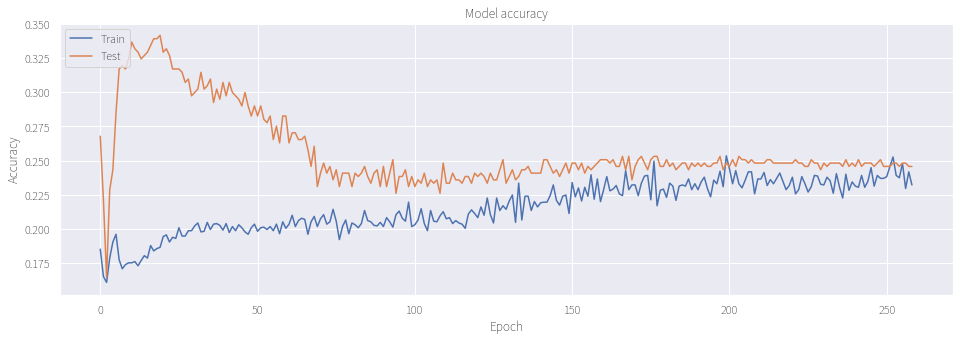

In [113]:
# 绘制训练 & 验证的准确率值
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Text(0.5, 1.0, 'Model loss')

Text(0, 0.5, 'Loss')

Text(0.5, 0, 'Epoch')

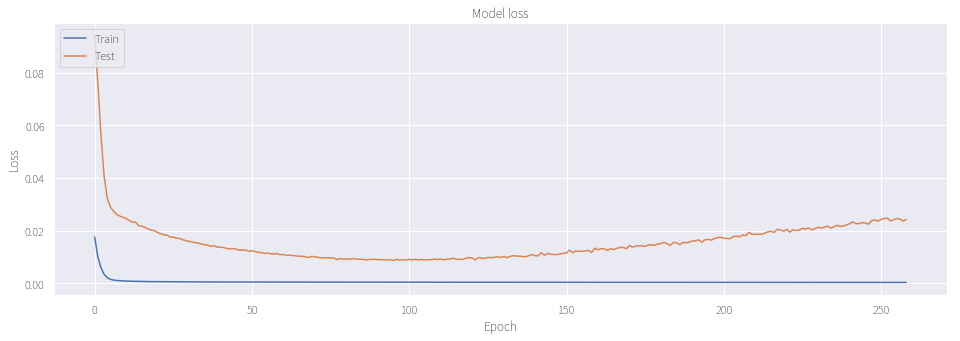

In [114]:
# 绘制训练 & 验证的损失值
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [117]:
X,Y=buildData(data_norm[-200:])

X_np=toNpArray(X)
Y_np=toNpArray(Y)

# x: 输入数据，Numpy 数组（或者如果模型有多个输入，则为 Numpy 数组列表）。
# batch_size: 整数。如未指定，默认为 32。
# verbose: 日志显示模式，0 或 1。
# steps: 声明预测结束之前的总步数（批次样本）。默认值 None。
Y_pred=model.predict(X_np,verbose=1)

165/165 [==============================] - 1s 4ms/step


In [123]:
Y_pred.shape

(165, 5)

In [124]:
Y_np.shape

(165, 5)

In [127]:
Y[0]

date
2018-04-24    0.411856
2018-04-25    0.396184
2018-04-26    0.389219
2018-04-27    0.397925
2018-05-02    0.394443
Name: close, dtype: float64

In [128]:
Y_np[0]

array([0.41185597, 0.39618413, 0.38921886, 0.39792544, 0.39444281])

In [133]:
test=[]
for i in range(len(Y_pred)):
    df=pd.DataFrame(Y_pred[i],index=Y[i].index,columns=['预测值']).join(Y[i])
    print(df)
    test.append(df)

                 预测值     close
date                          
2018-04-24  0.315718  0.411856
2018-04-25  0.215874  0.396184
2018-04-26  0.134312  0.389219
2018-04-27  0.160341  0.397925
2018-05-02  0.125316  0.394443
                 预测值     close
date                          
2018-04-25  0.333373  0.396184
2018-04-26  0.227290  0.389219
2018-04-27  0.145015  0.397925
2018-05-02  0.172795  0.394443
2018-05-03  0.142333  0.389219
                 预测值     close
date                          
2018-04-26  0.325862  0.389219
2018-04-27  0.221962  0.397925
2018-05-02  0.138693  0.394443
2018-05-03  0.168954  0.389219
2018-05-04  0.138830  0.382254
                 预测值     close
date                          
2018-04-27  0.315013  0.397925
2018-05-02  0.210746  0.394443
2018-05-03  0.129882  0.389219
2018-05-04  0.166699  0.382254
2018-05-07  0.129754  0.389219
                 预测值     close
date                          
2018-05-02  0.303198  0.394443
2018-05-03  0.195911  0.389219
2018-05-

                 预测值     close
date                          
2018-07-18  0.262850  0.304311
2018-07-19  0.203613  0.293399
2018-07-20  0.137914  0.347960
2018-07-23  0.143330  0.371603
2018-07-24  0.124549  0.373421
                 预测值     close
date                          
2018-07-19  0.257451  0.293399
2018-07-20  0.198142  0.347960
2018-07-23  0.132531  0.371603
2018-07-24  0.141457  0.373421
2018-07-25  0.122546  0.375240
                 预测值     close
date                          
2018-07-20  0.245936  0.347960
2018-07-23  0.189711  0.371603
2018-07-24  0.127234  0.373421
2018-07-25  0.139626  0.375240
2018-07-26  0.116487  0.362509
                 预测值     close
date                          
2018-07-23  0.245706  0.371603
2018-07-24  0.185107  0.373421
2018-07-25  0.128217  0.375240
2018-07-26  0.146237  0.362509
2018-07-27  0.113752  0.360690
                 预测值     close
date                          
2018-07-24  0.281744  0.373421
2018-07-25  0.208882  0.375240
2018-07-

                 预测值     close
date                          
2018-10-29  0.276392  0.367965
2018-10-30  0.196054  0.377059
2018-10-31  0.133079  0.377059
2018-11-01  0.166733  0.366147
2018-11-02  0.111616  0.378877
                 预测值     close
date                          
2018-10-30  0.299412  0.377059
2018-10-31  0.213653  0.377059
2018-11-01  0.142248  0.366147
2018-11-02  0.170253  0.378877
2018-11-05  0.122900  0.364328
                 预测值     close
date                          
2018-10-31  0.301868  0.377059
2018-11-01  0.213068  0.366147
2018-11-02  0.138418  0.378877
2018-11-05  0.170688  0.364328
2018-11-06  0.128733  0.358872
                 预测值     close
date                          
2018-11-01  0.298231  0.366147
2018-11-02  0.207590  0.378877
2018-11-05  0.133613  0.364328
2018-11-06  0.170580  0.358872
2018-11-07  0.126054  0.357053
                 预测值     close
date                          
2018-11-02  0.310460  0.378877
2018-11-05  0.214354  0.364328
2018-11-

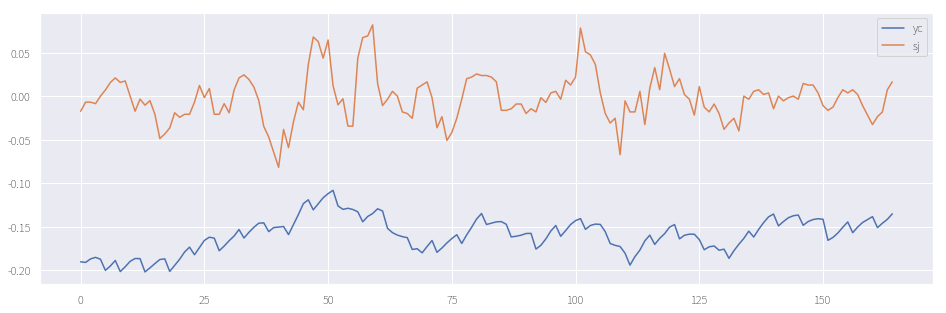

In [150]:
ce_yc=[]
ce_sj=[]
for t in test:
    ce=t.iloc[-1]-t.iloc[0]#差额
    ce_yc.append(ce['预测值'])
    ce_sj.append(ce['close'])
sns.lineplot(x=range(len(ce_yc)),y=ce_yc,label='yc')
sns.lineplot(x=range(len(ce_sj)),y=ce_sj,label='sj')

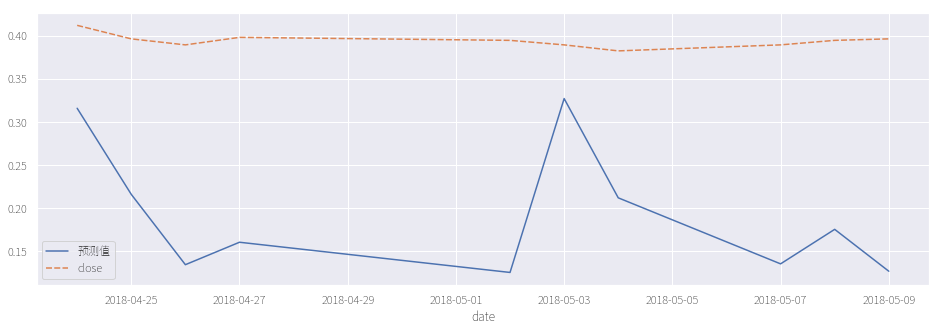

In [154]:
sns.lineplot(data=test[0].append(test[5]))